# 다산콜센터 질의-응답 데이터 EDA

## 데이터셋 개요
- **출처**: AI Hub - 민원(콜센터) 질의-응답 데이터
- **도메인**: 다산콜센터 (서울시 120 콜센터)
- **데이터 형태**: 질의-응답 대화쌍 + 음성 데이터
- **카테고리**: 
  - 대중교통 안내
  - 코로나19 관련 상담
  - 일반행정 문의
  - 생활하수도 관련 문의

---

## 1. Setup & 한국어 폰트 설정

In [1]:
import os
import json
from pathlib import Path
from collections import Counter, defaultdict
from typing import Dict, List, Any

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from tqdm.notebook import tqdm

# Pandas display options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", 100)

# Visualization settings
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")
%matplotlib inline

In [3]:
# 한국어 폰트 설정 (macOS/Windows/Linux 호환)
def setup_korean_font():
    """
    한국어 폰트를 자동으로 찾아서 설정합니다.
    macOS, Windows, Linux에서 모두 작동합니다.
    """
    # 시스템별 한국어 폰트 후보
    font_candidates = [
        # macOS
        "AppleGothic",
        "Apple SD Gothic Neo",
        "AppleMyungjo",
        # Windows
        "Malgun Gothic",
        "Gulim",
        "Batang",
        "Dotum",
        # Linux
        "NanumGothic",
        "NanumBarunGothic",
        "UnDotum",
        # 기타
        "DejaVu Sans",
    ]

    # 사용 가능한 폰트 찾기
    available_fonts = [f.name for f in fm.fontManager.ttflist]

    for font_name in font_candidates:
        if font_name in available_fonts:
            plt.rcParams["font.family"] = font_name
            plt.rcParams["axes.unicode_minus"] = False  # 마이너스 기호 깨짐 방지
            print(f"✓ 한국어 폰트 설정: {font_name}")
            return font_name

    # 폰트를 찾지 못한 경우
    print("⚠️  한국어 폰트를 찾을 수 없습니다. 기본 폰트를 사용합니다.")
    print("   나눔고딕 설치 권장: https://hangeul.naver.com/2017/nanum")
    return None


# 폰트 설정 실행
korean_font = setup_korean_font()
print("\n사용 가능한 한국어 폰트 목록 (처음 10개):")
korean_fonts = [
    f.name
    for f in fm.fontManager.ttflist
    if "Korean" in f.name or "Hangul" in f.name or "Nanum" in f.name
]
for font in korean_fonts[:10]:
    print(f"  - {font}")

✓ 한국어 폰트 설정: AppleGothic

사용 가능한 한국어 폰트 목록 (처음 10개):
  - NanumSquareOTF_ac
  - NanumSquareOTF
  - Nanum Gothic
  - Nanum Brush Script
  - NanumSquareOTF
  - NanumSquareOTF
  - NanumSquareOTF_ac
  - NanumSquareOTF_ac
  - NanumSquareOTF_ac
  - NanumSquareOTF


## 2. 데이터 경로 설정

In [4]:
# Base paths
BASE_DIR = Path("/Users/sdh/Dev/02_production_projects/humetro-ai-assistant")
DATA_DIR = BASE_DIR / "data/dasan_call/extracted"
OUTPUT_DIR = BASE_DIR / "data/processed/dasan_eda"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Data paths
TRAINING_LABELED = DATA_DIR / "training/labeled"
TRAINING_SOURCE = DATA_DIR / "training/source"
VALIDATION_LABELED = DATA_DIR / "validation/labeled"
VALIDATION_SOURCE = DATA_DIR / "validation/source"

print(f"Data Directory: {DATA_DIR}")
print(f"Output Directory: {OUTPUT_DIR}")
print(f"\nData exists: {DATA_DIR.exists()}")

Data Directory: /Users/sdh/Dev/02_production_projects/humetro-ai-assistant/data/dasan_call/extracted
Output Directory: /Users/sdh/Dev/02_production_projects/humetro-ai-assistant/data/processed/dasan_eda

Data exists: True


## 3. 데이터 로드 함수

In [5]:
def load_json_files(directory: Path) -> pd.DataFrame:
    """
    디렉토리에서 모든 JSON 파일을 로드하여 DataFrame으로 반환

    Args:
        directory: JSON 파일이 있는 디렉토리 경로

    Returns:
        통합된 DataFrame
    """
    all_data = []
    json_files = list(directory.glob("*.json"))

    print(f"Loading {len(json_files)} JSON files from {directory.name}...")

    for json_file in tqdm(json_files, desc="Loading files"):
        try:
            with open(json_file, "r", encoding="utf-8") as f:
                data = json.load(f)

                # 파일명에서 카테고리 추출
                filename = json_file.stem

                # DataFrame 생성
                if isinstance(data, list):
                    df = pd.DataFrame(data)
                    df["source_file"] = filename
                    all_data.append(df)

        except Exception as e:
            print(f"Error loading {json_file.name}: {e}")

    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        print(f"✓ Loaded {len(combined_df):,} records")
        return combined_df
    else:
        print("⚠️  No data loaded")
        return pd.DataFrame()

## 4. Training 데이터 로드

In [9]:
# Load training data
print("=" * 60)
print("LOADING TRAINING DATA")
print("=" * 60)
training_df = load_json_files(TRAINING_LABELED)

print(f"\nTraining data shape: {training_df.shape}")
print(f"Columns: {list(training_df.columns)}")
training_df.head(100)

LOADING TRAINING DATA
Loading 4 JSON files from labeled...


Loading files:   0%|          | 0/4 [00:00<?, ?it/s]

✓ Loaded 162,394 records

Training data shape: (162394, 16)
Columns: ['도메인', '카테고리', '대화셋일련번호', '화자', '문장번호', '고객의도', '상담사의도', 'QA', '고객질문(요청)', '상담사질문(요청)', '고객답변', '상담사답변', '개체명 ', '용어사전', '지식베이스', 'source_file']


,도메인,카테고리,대화셋일련번호,화자,문장번호,고객의도,상담사의도,QA,고객질문(요청),상담사질문(요청),고객답변,상담사답변,개체명,용어사전,지식베이스,source_file
0,다산콜센터,코로나19 관련 상담,B2425,고객,1,정부지원,,Q,자가격리시 정부의 지원에 대해 알고싶습니다.,,,,자가격리,본인주택격리/질병관리체계,"자가격리,질병관리체계",민원(콜센터) 질의응답_다산콜센터_코로나19 관련 상담_Training
1,다산콜센터,코로나19 관련 상담,B2425,상담사,2,,정부지원,A,,,,네 무엇이 궁금하신지요?,,,,민원(콜센터) 질의응답_다산콜센터_코로나19 관련 상담_Training
2,다산콜센터,코로나19 관련 상담,B2425,고객,3,정부지원,,Q,자가격리시 일을 못하는데 어떻게 하나요?,,,,자가격리,,자가격리,민원(콜센터) 질의응답_다산콜센터_코로나19 관련 상담_Training
3,다산콜센터,코로나19 관련 상담,B2425,상담사,4,,정부지원,A,,,,정부에서 별도 지원금을 지급하고 있습니다.,지원금,보조금/돈,"지원금,돈",민원(콜센터) 질의응답_다산콜센터_코로나19 관련 상담_Training
4,다산콜센터,코로나19 관련 상담,B2425,고객,5,정부지원,,Q,모든 사람이 받을 수 있나요?,,,,사람,사람/인간,"사람,인간",민원(콜센터) 질의응답_다산콜센터_코로나19 관련 상담_Training
5,다산콜센터,코로나19 관련 상담,B2425,상담사,6,,정부지원,A,,,,일용직 노동자 등 취약노동자들이 받을 수 있습니다.,"일용직, 노동자",임시직/사람/ 근로자/사람,"노동자,사람",민원(콜센터) 질의응답_다산콜센터_코로나19 관련 상담_Training
6,다산콜센터,코로나19 관련 상담,B2425,고객,7,정부지원,,Q,대상이 어떻게 되나요?,,,,대상,,대상,민원(콜센터) 질의응답_다산콜센터_코로나19 관련 상담_Training
7,다산콜센터,코로나19 관련 상담,B2425,상담사,8,,정부지원,A,,,,"주 40시간 미만 단시간 노동자, 일용직 노동자, 특수형태노동종사자, 요양보호사가 해당됩니다.","일용직, 노동자",임시직/사람/ 근로자/사람,"노동자,사람",민원(콜센터) 질의응답_다산콜센터_코로나19 관련 상담_Training
8,다산콜센터,코로나19 관련 상담,B2425,고객,9,정부지원,,Q,얼마나 지원되나요?,,,,지원,,지원,민원(콜센터) 질의응답_다산콜센터_코로나19 관련 상담_Training
9,다산콜센터,코로나19 관련 상담,B2425,상담사,10,,정부지원,A,,,,1인당 23만원이 지급됩니다.,"1인당,23만원,지급",,23만원,민원(콜센터) 질의응답_다산콜센터_코로나19 관련 상담_Training


## 5. Validation 데이터 로드

In [7]:
# Load validation data
print("=" * 60)
print("LOADING VALIDATION DATA")
print("=" * 60)
validation_df = load_json_files(VALIDATION_LABELED)

print(f"\nValidation data shape: {validation_df.shape}")
validation_df.head()

LOADING VALIDATION DATA
Loading 4 JSON files from labeled...


Loading files:   0%|          | 0/4 [00:00<?, ?it/s]

✓ Loaded 20,325 records

Validation data shape: (20325, 16)


,도메인,카테고리,대화셋일련번호,화자,문장번호,고객의도,상담사의도,QA,고객질문(요청),상담사질문(요청),고객답변,상담사답변,개체명,용어사전,지식베이스,source_file
0,다산콜센터,코로나19 관련 상담,B36183,고객,1,방역수칙,,Q,2단계 거리두기 언제부터 시행되었는지 알 수 있나요?,,,,"서울, 사회적거리,시작",서울/지역,"사회적거리,지역",민원(콜센터) 질의응답_다산콜센터_코로나19 관련 상담_Validation
1,다산콜센터,코로나19 관련 상담,B36183,상담사,2,,방역수칙,A,,,,서울은 8월 19일부터 2단계가 시행되었습니다.,"서울, 시행",서울/지역,"시행,지역",민원(콜센터) 질의응답_다산콜센터_코로나19 관련 상담_Validation
2,다산콜센터,코로나19 관련 상담,B36183,고객,3,방역수칙,,Q,"몇명이상 집합, 모임, 행사가 금지되나요?",,,,"집합, 모임, 행사, 금지","집합, 모임, 행사, 금지","모임,금지",민원(콜센터) 질의응답_다산콜센터_코로나19 관련 상담_Validation
3,다산콜센터,코로나19 관련 상담,B36183,상담사,4,,방역수칙,Q,,실내요?,,,실내,실내/공간,"실내,공간",민원(콜센터) 질의응답_다산콜센터_코로나19 관련 상담_Validation
4,다산콜센터,코로나19 관련 상담,B36183,고객,5,방역수칙,,A,,,실내와 실외가 다 궁금합니다.,,"실내, 실외","실내/공간, 실외/공간","실외,공간",민원(콜센터) 질의응답_다산콜센터_코로나19 관련 상담_Validation


## 6. 데이터 통합

In [10]:
# Add split column
training_df["split"] = "Training"
validation_df["split"] = "Validation"

# Combine datasets
full_df = pd.concat([training_df, validation_df], ignore_index=True)

print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"Total records: {len(full_df):,}")
print(f"Training: {len(training_df):,} ({len(training_df) / len(full_df) * 100:.1f}%)")
print(
    f"Validation: {len(validation_df):,} ({len(validation_df) / len(full_df) * 100:.1f}%)"
)
print()
print("Data types:")
print(full_df.dtypes)

DATASET OVERVIEW
Total records: 182,719
Training: 162,394 (88.9%)
Validation: 20,325 (11.1%)

Data types:
도메인            object
카테고리           object
대화셋일련번호        object
화자             object
문장번호           object
고객의도           object
상담사의도          object
QA             object
고객질문(요청)       object
상담사질문(요청)      object
고객답변           object
상담사답변          object
개체명            object
용어사전           object
지식베이스          object
source_file    object
split          object
dtype: object


## 7. 기본 통계

In [ ]:
# 도메인 분포
print("=" * 60)
print("도메인 분포")
print("=" * 60)
print(full_df["도메인"].value_counts())
print()

# 카테고리 분포
print("=" * 60)
print("카테고리 분포")
print("=" * 60)
print(full_df["카테고리"].value_counts())
print()

# 화자 분포
print("=" * 60)
print("화자 분포")
print("=" * 60)
print(full_df["화자"].value_counts())

도메인 분포
도메인
다산콜센터    182719
Name: count, dtype: int64

카테고리 분포
카테고리
일반행정 문의        56647
생활하수도 관련 문의    45705
대중교통 안내        43829
코로나19 관련 상담    36538
Name: count, dtype: int64

화자 분포
화자
고객     93660
상담사    89059
Name: count, dtype: int64


## 8. 카테고리별 분석

카테고리별 레코드 수
split        Training  Validation  Total
카테고리                                    
일반행정 문의         50336        6311  56647
생활하수도 관련 문의     40617        5088  45705
대중교통 안내         38966        4863  43829
코로나19 관련 상담     32475        4063  36538



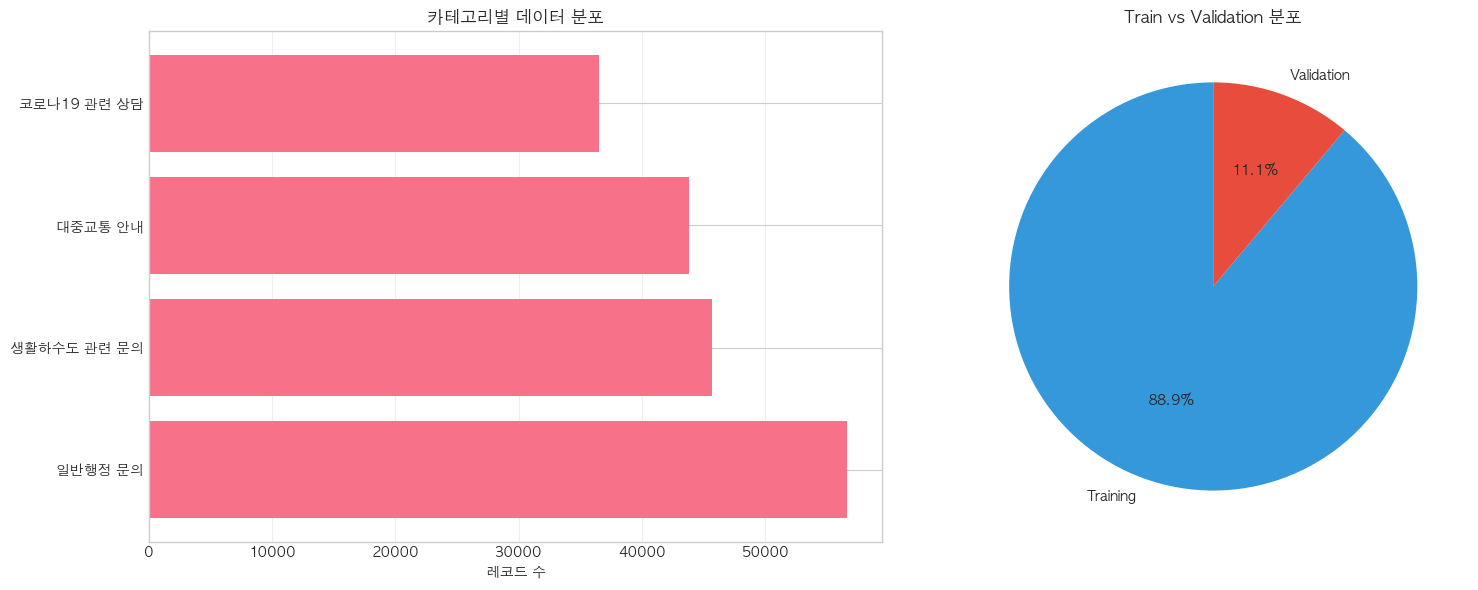

✓ 시각화 저장: /Users/sdh/Dev/02_production_projects/humetro-ai-assistant/data/processed/dasan_eda/category_distribution.png


In [11]:
# 카테고리별 통계
category_stats = full_df.groupby(["카테고리", "split"]).size().unstack(fill_value=0)
category_stats["Total"] = category_stats.sum(axis=1)
category_stats = category_stats.sort_values("Total", ascending=False)

print("=" * 60)
print("카테고리별 레코드 수")
print("=" * 60)
print(category_stats)
print()

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 카테고리별 분포
category_counts = full_df["카테고리"].value_counts()
axes[0].barh(range(len(category_counts)), category_counts.values)
axes[0].set_yticks(range(len(category_counts)))
axes[0].set_yticklabels(category_counts.index)
axes[0].set_xlabel("레코드 수")
axes[0].set_title("카테고리별 데이터 분포")
axes[0].grid(axis="x", alpha=0.3)

# Train/Validation 분포
split_counts = full_df["split"].value_counts()
axes[1].pie(
    split_counts.values,
    labels=split_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=["#3498db", "#e74c3c"],
)
axes[1].set_title("Train vs Validation 분포")

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "category_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"✓ 시각화 저장: {OUTPUT_DIR / 'category_distribution.png'}")

## 9. 대화쌍 분석

대화쌍 통계
총 대화 수: 9,185
평균 턴 수: 19.89
최대 턴 수: 75
최소 턴 수: 1

턴 수 분포:
count    9185.000000
mean       19.893195
std         2.512690
min         1.000000
25%        20.000000
50%        20.000000
75%        20.000000
max        75.000000
Name: num_turns, dtype: float64


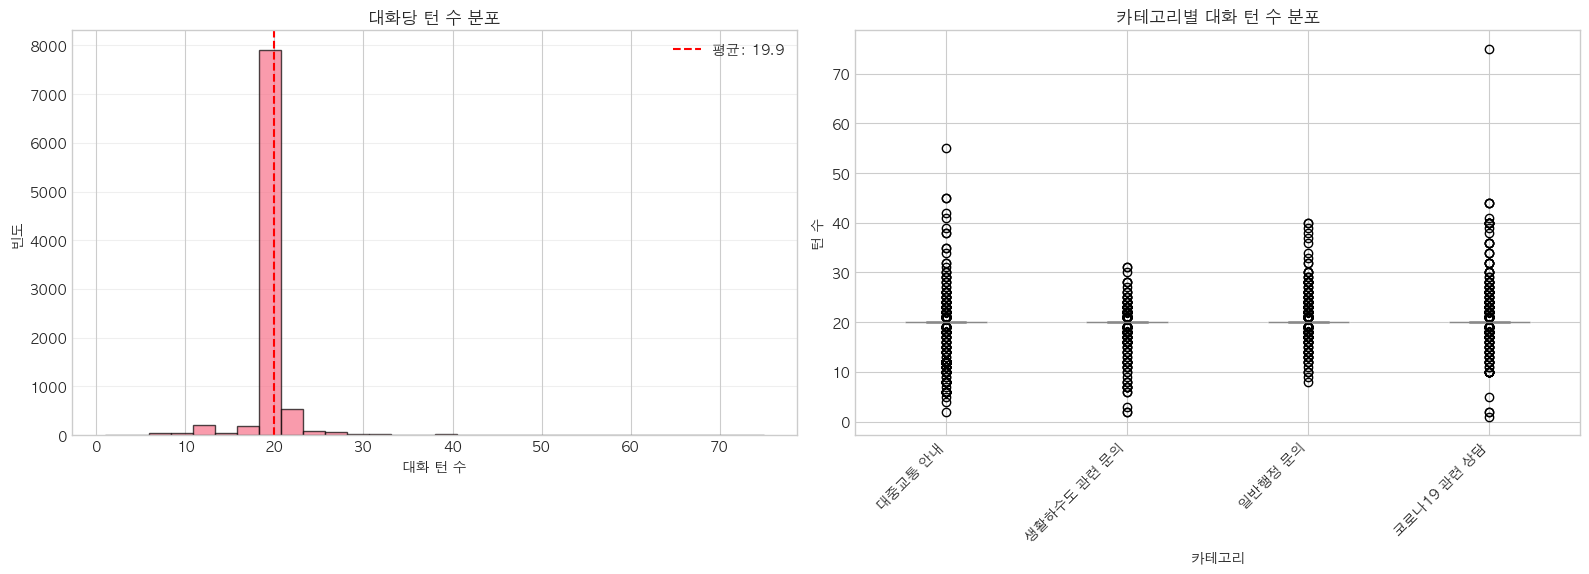

✓ 시각화 저장: /Users/sdh/Dev/02_production_projects/humetro-ai-assistant/data/processed/dasan_eda/dialogue_turns_analysis.png


In [12]:
# 대화셋 일련번호별 통계
dialogue_stats = (
    full_df.groupby("대화셋일련번호")
    .agg({"문장번호": "count", "카테고리": "first"})
    .rename(columns={"문장번호": "num_turns"})
)

print("=" * 60)
print("대화쌍 통계")
print("=" * 60)
print(f"총 대화 수: {len(dialogue_stats):,}")
print(f"평균 턴 수: {dialogue_stats['num_turns'].mean():.2f}")
print(f"최대 턴 수: {dialogue_stats['num_turns'].max()}")
print(f"최소 턴 수: {dialogue_stats['num_turns'].min()}")
print()
print("턴 수 분포:")
print(dialogue_stats["num_turns"].describe())

# 턴 수 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 히스토그램
axes[0].hist(dialogue_stats["num_turns"], bins=30, edgecolor="black", alpha=0.7)
axes[0].axvline(
    dialogue_stats["num_turns"].mean(),
    color="red",
    linestyle="--",
    label=f"평균: {dialogue_stats['num_turns'].mean():.1f}",
)
axes[0].set_xlabel("대화 턴 수")
axes[0].set_ylabel("빈도")
axes[0].set_title("대화당 턴 수 분포")
axes[0].legend()
axes[0].grid(axis="y", alpha=0.3)

# 박스플롯 (카테고리별)
category_turns = (
    full_df.groupby(["카테고리", "대화셋일련번호"]).size().reset_index(name="turns")
)
category_turns.boxplot(column="turns", by="카테고리", ax=axes[1])
axes[1].set_xlabel("카테고리")
axes[1].set_ylabel("턴 수")
axes[1].set_title("카테고리별 대화 턴 수 분포")
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha="right")
plt.suptitle("")  # Remove default title

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "dialogue_turns_analysis.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"✓ 시각화 저장: {OUTPUT_DIR / 'dialogue_turns_analysis.png'}")

## 10. QA 구조 분석

QA 구조 분석
QA
A    101099
Q     81620
Name: count, dtype: int64

화자별 QA 분포:
QA       A      Q
화자               
고객   33087  60573
상담사  68012  21047


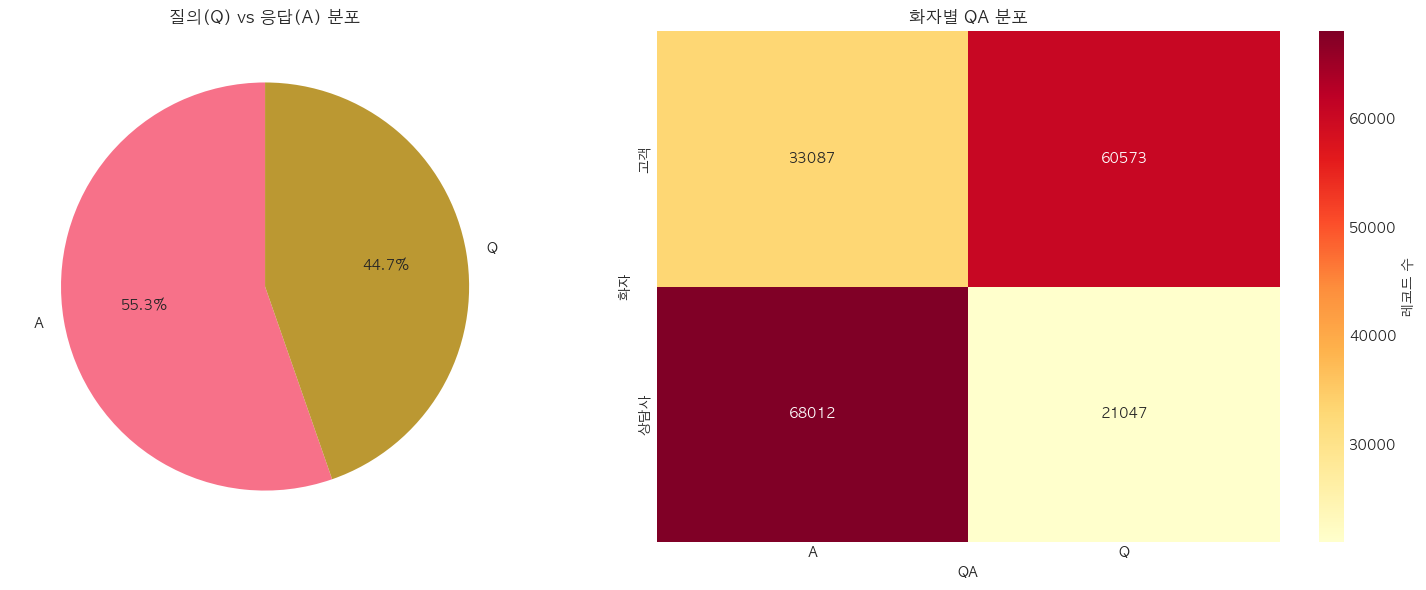

✓ 시각화 저장: /Users/sdh/Dev/02_production_projects/humetro-ai-assistant/data/processed/dasan_eda/qa_structure_analysis.png


In [ ]:
# QA 분포
print("=" * 60)
print("QA 구조 분석")
print("=" * 60)
qa_dist = full_df["QA"].value_counts()
print(qa_dist)
print()

# 화자별 QA 분포
speaker_qa = pd.crosstab(full_df["화자"], full_df["QA"])
print("화자별 QA 분포:")
print(speaker_qa)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# QA 분포 파이차트
axes[0].pie(qa_dist.values, labels=qa_dist.index, autopct="%1.1f%%", startangle=90)
axes[0].set_title("질의(Q) vs 응답(A) 분포")

# 화자별 QA 히트맵
sns.heatmap(
    speaker_qa,
    annot=True,
    fmt="d",
    cmap="YlOrRd",
    ax=axes[1],
    cbar_kws={"label": "레코드 수"},
)
axes[1].set_title("화자별 QA 분포")
axes[1].set_xlabel("QA")
axes[1].set_ylabel("화자")

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "qa_structure_analysis.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"✓ 시각화 저장: {OUTPUT_DIR / 'qa_structure_analysis.png'}")

## 11. 의도 분석

고객 의도 TOP 20
고객의도
            89075
버스노선         2597
지원금          1962
상수도          1914
방역지침         1835
문화행사 정보      1500
재난지원금        1463
시내버스 시간      1392
지원금문의        1314
교통 정보 문의     1287
수도요금         1118
버스 노선         954
노선문의          921
지원금 대상        868
시설이용          744
교통정보          740
지원금 신청        660
지하철 여부        660
문화행사          630
납부내역 조회       580
Name: count, dtype: int64

상담사 의도 TOP 20
상담사의도
            93674
버스노선         2449
방역지침         1801
지원금          1788
상수도          1690
문화행사 정보      1500
시내버스 시간      1388
재난지원금        1386
지원금문의        1252
교통 정보 문의     1222
수도요금         1081
버스 노선        1045
노선문의          913
지원금 대상        868
교통정보          738
시설이용          723
지원금 신청        660
지하철 여부        660
문화행사          611
기차문의          581
Name: count, dtype: int64


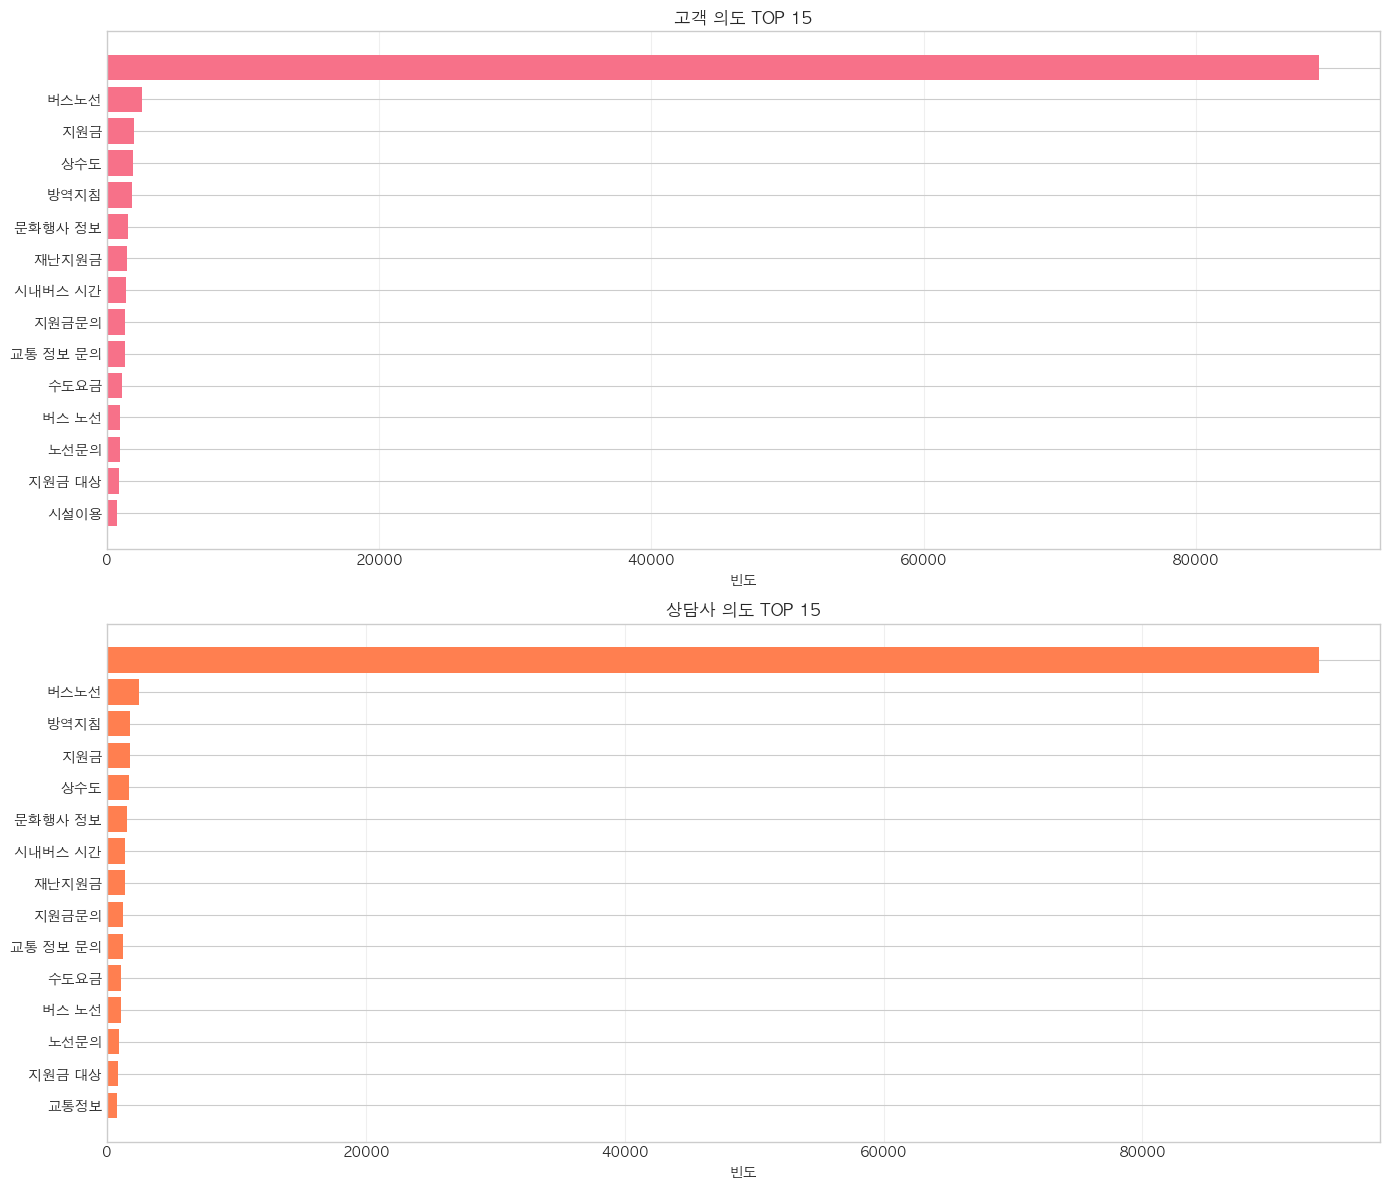

✓ 시각화 저장: /Users/sdh/Dev/02_production_projects/humetro-ai-assistant/data/processed/dasan_eda/intent_analysis.png


In [ ]:
# 고객 의도 분석
print("=" * 60)
print("고객 의도 TOP 20")
print("=" * 60)
customer_intent = full_df["고객의도"].value_counts().head(20)
print(customer_intent)
print()

# 상담사 의도 분석
print("=" * 60)
print("상담사 의도 TOP 20")
print("=" * 60)
agent_intent = full_df["상담사의도"].value_counts().head(20)
print(agent_intent)

# 시각화
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# 고객 의도 TOP 15
top_customer = customer_intent.head(15)
axes[0].barh(range(len(top_customer)), top_customer.values)
axes[0].set_yticks(range(len(top_customer)))
axes[0].set_yticklabels(top_customer.index)
axes[0].set_xlabel("빈도")
axes[0].set_title("고객 의도 TOP 15")
axes[0].grid(axis="x", alpha=0.3)
axes[0].invert_yaxis()

# 상담사 의도 TOP 15
top_agent = agent_intent.head(15)
axes[1].barh(range(len(top_agent)), top_agent.values, color="coral")
axes[1].set_yticks(range(len(top_agent)))
axes[1].set_yticklabels(top_agent.index)
axes[1].set_xlabel("빈도")
axes[1].set_title("상담사 의도 TOP 15")
axes[1].grid(axis="x", alpha=0.3)
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "intent_analysis.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"✓ 시각화 저장: {OUTPUT_DIR / 'intent_analysis.png'}")

## 12. 텍스트 길이 분석

텍스트 길이 통계
       customer_q_len  customer_a_len    agent_q_len    agent_a_len
count   182719.000000   182719.000000  182719.000000  182719.000000
mean         6.426885        2.532178       1.931945       9.982383
std         10.362679        6.594351       5.875687      20.095750
min          0.000000        0.000000       0.000000       0.000000
25%          0.000000        0.000000       0.000000       0.000000
50%          0.000000        0.000000       0.000000       0.000000
75%         13.000000        0.000000       0.000000      17.000000
max        110.000000      109.000000     245.000000    2062.000000


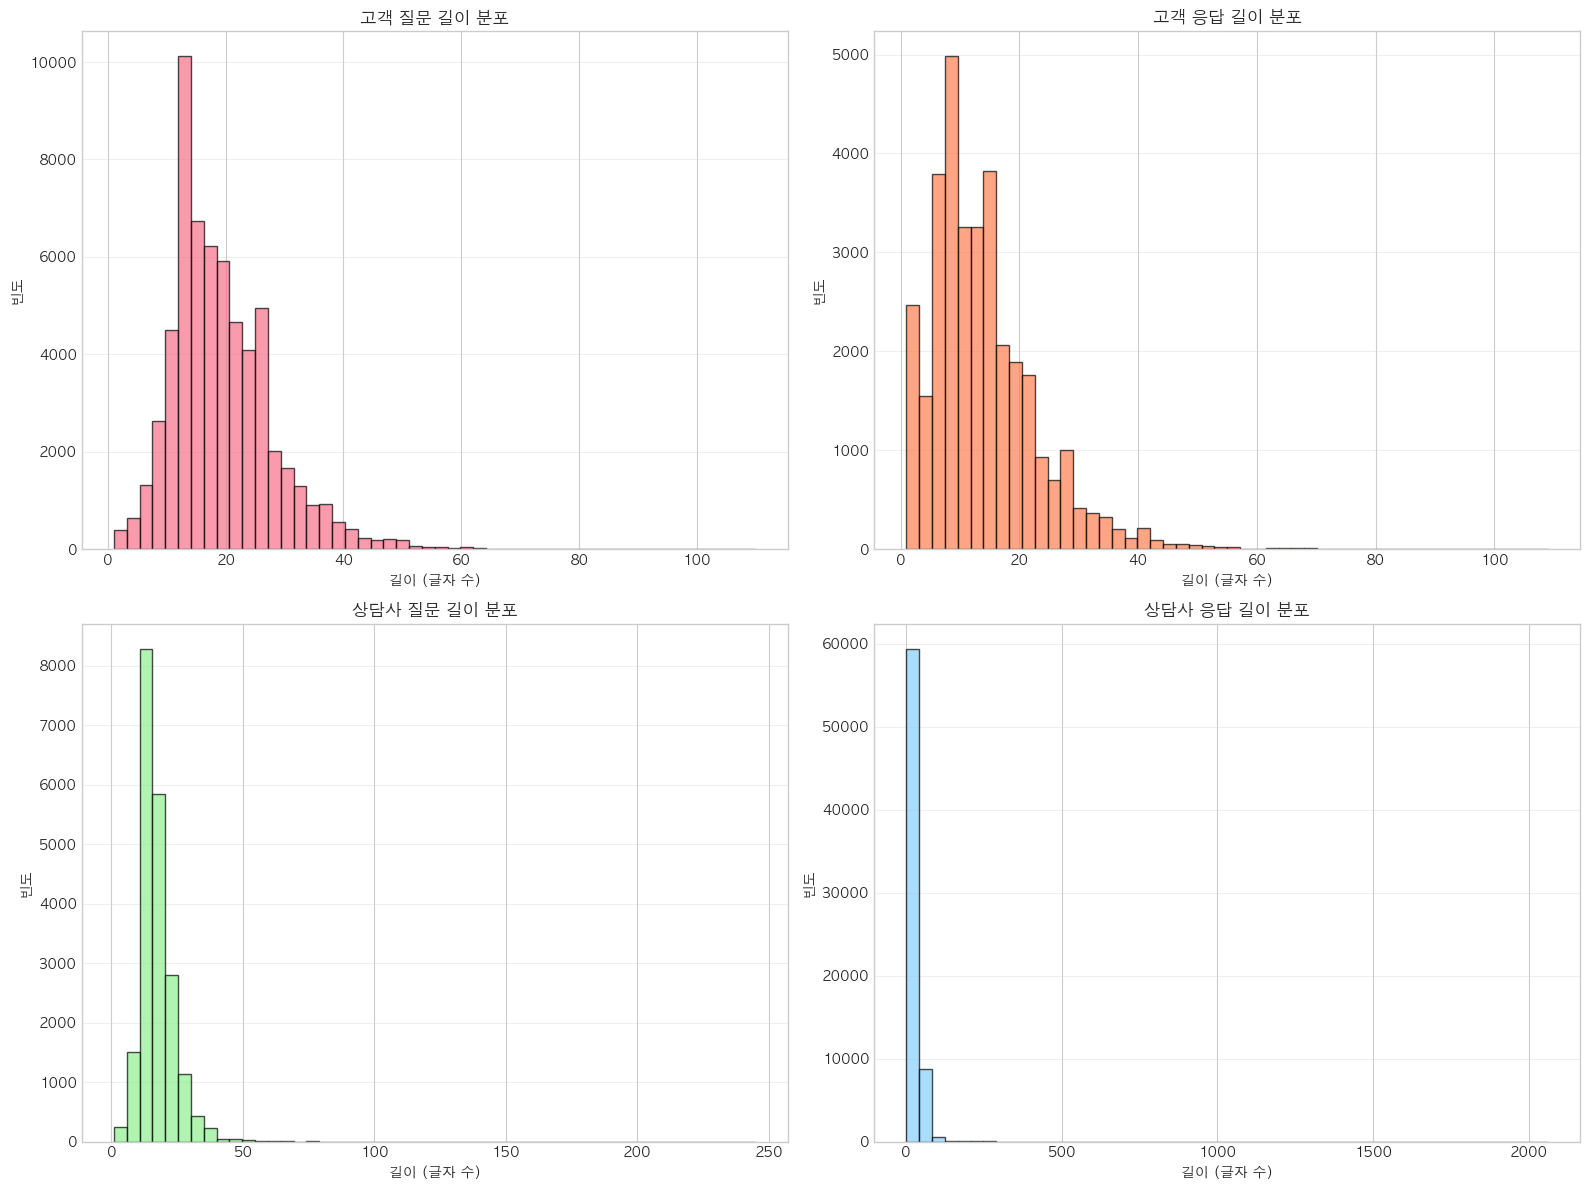

✓ 시각화 저장: /Users/sdh/Dev/02_production_projects/humetro-ai-assistant/data/processed/dasan_eda/text_length_analysis.png


In [13]:
# 고객 질문/응답 길이
full_df["customer_q_len"] = full_df["고객질문(요청)"].fillna("").str.len()
full_df["customer_a_len"] = full_df["고객답변"].fillna("").str.len()

# 상담사 질문/응답 길이
full_df["agent_q_len"] = full_df["상담사질문(요청)"].fillna("").str.len()
full_df["agent_a_len"] = full_df["상담사답변"].fillna("").str.len()

print("=" * 60)
print("텍스트 길이 통계")
print("=" * 60)
length_stats = full_df[
    ["customer_q_len", "customer_a_len", "agent_q_len", "agent_a_len"]
].describe()
print(length_stats)

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 고객 질문 길이
axes[0, 0].hist(
    full_df[full_df["customer_q_len"] > 0]["customer_q_len"],
    bins=50,
    edgecolor="black",
    alpha=0.7,
)
axes[0, 0].set_xlabel("길이 (글자 수)")
axes[0, 0].set_ylabel("빈도")
axes[0, 0].set_title("고객 질문 길이 분포")
axes[0, 0].grid(axis="y", alpha=0.3)

# 고객 응답 길이
axes[0, 1].hist(
    full_df[full_df["customer_a_len"] > 0]["customer_a_len"],
    bins=50,
    edgecolor="black",
    alpha=0.7,
    color="coral",
)
axes[0, 1].set_xlabel("길이 (글자 수)")
axes[0, 1].set_ylabel("빈도")
axes[0, 1].set_title("고객 응답 길이 분포")
axes[0, 1].grid(axis="y", alpha=0.3)

# 상담사 질문 길이
axes[1, 0].hist(
    full_df[full_df["agent_q_len"] > 0]["agent_q_len"],
    bins=50,
    edgecolor="black",
    alpha=0.7,
    color="lightgreen",
)
axes[1, 0].set_xlabel("길이 (글자 수)")
axes[1, 0].set_ylabel("빈도")
axes[1, 0].set_title("상담사 질문 길이 분포")
axes[1, 0].grid(axis="y", alpha=0.3)

# 상담사 응답 길이
axes[1, 1].hist(
    full_df[full_df["agent_a_len"] > 0]["agent_a_len"],
    bins=50,
    edgecolor="black",
    alpha=0.7,
    color="lightskyblue",
)
axes[1, 1].set_xlabel("길이 (글자 수)")
axes[1, 1].set_ylabel("빈도")
axes[1, 1].set_title("상담사 응답 길이 분포")
axes[1, 1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "text_length_analysis.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"✓ 시각화 저장: {OUTPUT_DIR / 'text_length_analysis.png'}")

## 13. 개체명/용어사전/지식베이스 분석

개체명 분석
개체명이 있는 레코드: 81.20%

용어사전이 있는 레코드: 76.88%

지식베이스가 있는 레코드: 80.91%


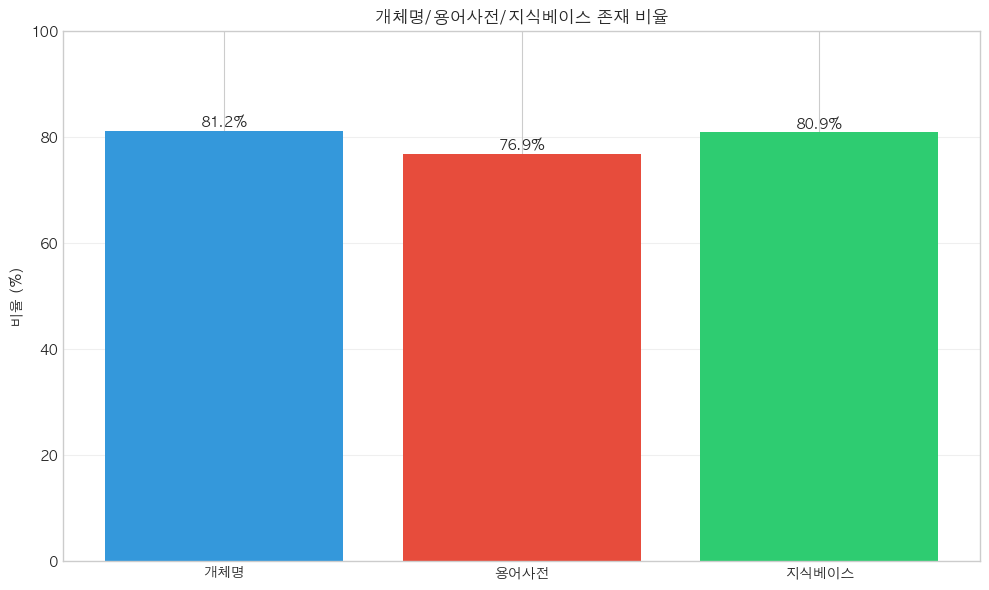

✓ 시각화 저장: /Users/sdh/Dev/02_production_projects/humetro-ai-assistant/data/processed/dasan_eda/annotation_analysis.png


In [14]:
# 개체명 분석
print("=" * 60)
print("개체명 분석")
print("=" * 60)

# 개체명이 있는 레코드 비율
entity_ratio = (
    (full_df["개체명 "].notna() & (full_df["개체명 "] != "")).sum() / len(full_df) * 100
)
print(f"개체명이 있는 레코드: {entity_ratio:.2f}%")
print()

# 용어사전이 있는 레코드 비율
term_ratio = (
    (full_df["용어사전"].notna() & (full_df["용어사전"] != "")).sum()
    / len(full_df)
    * 100
)
print(f"용어사전이 있는 레코드: {term_ratio:.2f}%")
print()

# 지식베이스가 있는 레코드 비율
kb_ratio = (
    (full_df["지식베이스"].notna() & (full_df["지식베이스"] != "")).sum()
    / len(full_df)
    * 100
)
print(f"지식베이스가 있는 레코드: {kb_ratio:.2f}%")

# 시각화
fig, ax = plt.subplots(figsize=(10, 6))

categories = ["개체명", "용어사전", "지식베이스"]
ratios = [entity_ratio, term_ratio, kb_ratio]

bars = ax.bar(categories, ratios, color=["#3498db", "#e74c3c", "#2ecc71"])
ax.set_ylabel("비율 (%)")
ax.set_title("개체명/용어사전/지식베이스 존재 비율")
ax.set_ylim(0, 100)
ax.grid(axis="y", alpha=0.3)

# 값 표시
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:.1f}%",
        ha="center",
        va="bottom",
    )

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "annotation_analysis.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"✓ 시각화 저장: {OUTPUT_DIR / 'annotation_analysis.png'}")

## 14. 샘플 데이터 확인

In [15]:
# 각 카테고리별 샘플 대화 1개씩 출력
print("=" * 60)
print("카테고리별 샘플 대화")
print("=" * 60)

for category in full_df["카테고리"].unique():
    print(f"\n{'=' * 60}")
    print(f"카테고리: {category}")
    print("=" * 60)

    # 해당 카테고리의 첫 번째 대화 선택
    category_data = full_df[full_df["카테고리"] == category]
    first_dialogue_id = category_data["대화셋일련번호"].iloc[0]
    dialogue = category_data[
        category_data["대화셋일련번호"] == first_dialogue_id
    ].sort_values("문장번호")

    print(f"대화 ID: {first_dialogue_id}")
    print(f"턴 수: {len(dialogue)}\n")

    for _, row in dialogue.head(5).iterrows():
        speaker = "고객" if row["화자"] == "고객" else "상담사"
        qa = row["QA"]

        if qa == "Q":
            text = (
                row["고객질문(요청)"] if speaker == "고객" else row["상담사질문(요청)"]
            )
        else:
            text = row["고객답변"] if speaker == "고객" else row["상담사답변"]

        if pd.notna(text) and text:
            print(f"[{speaker}] {text}")

    if len(dialogue) > 5:
        print(f"... (총 {len(dialogue)}턴)")

카테고리별 샘플 대화

카테고리: 코로나19 관련 상담


대화 ID: B2425
턴 수: 20

[고객] 자가격리시 정부의 지원에 대해 알고싶습니다.
[상담사] 1인당 23만원이 지급됩니다.
[고객] 신청은 어떻게 하나요?
[상담사] 신청기간은 이번달 15일부터 12월 11일까지 입니다.
[고객] 필요서류가 있나요?
... (총 20턴)

카테고리: 대중교통 안내
대화 ID: B2033
턴 수: 8

[고객] 서울 가산동에서 남대문시장가는 버스노선을 알고싶습니다
[상담사] 가산동 어디에서 출발하십니까?
[고객] 가산동 주민센터입니다.
[상담사] 가산동 주민센터에서 남대문시장으로 가는 버스노선은 505번 버스입니다.
[고객] 어느정류장에서 타야합니까?
... (총 8턴)

카테고리: 생활하수도 관련 문의
대화 ID: B2355
턴 수: 20

[고객] 수도 계량기가 고장난 것 같습니다.
[고객] OOO, 서울시 강남구 OOO입니다.
[상담사] 신청완료해 드렸습니다.
[상담사] 더 궁금한 사항 있으십니까?
[고객] 교체는 언제쯤 하러옵니까?
... (총 20턴)

카테고리: 일반행정 문의
대화 ID: B2240
턴 수: 20

[고객] 지방세를 내려면 어떻게 해야됩니까?
[상담사] 어느지점으로 안내해드릴까요?
[고객] 서울역근처로 안내 부탁합니다.
[상담사] 도보로 10분위치에 서울역지점이 있습니다.
[고객] 버스로 가는 방법도 있습니까?
... (총 20턴)


## 15. 데이터 품질 체크

In [16]:
print("=" * 60)
print("데이터 품질 체크")
print("=" * 60)

# 결측값 확인
print("\n결측값:")
missing = full_df.isnull().sum()
missing_pct = (missing / len(full_df) * 100).round(2)
missing_df = pd.DataFrame({"Count": missing, "Percentage": missing_pct})
print(missing_df[missing_df["Count"] > 0])

# 중복 대화셋 확인
duplicate_dialogues = full_df["대화셋일련번호"].duplicated().sum()
print(f"\n중복 문장 (같은 대화셋 내): {duplicate_dialogues:,}")

# 화자별 레코드 수
print("\n화자별 레코드 수:")
print(full_df["화자"].value_counts())

# 빈 텍스트 확인
empty_customer_q = (
    full_df["고객질문(요청)"].isna() | (full_df["고객질문(요청)"] == "")
).sum()
empty_customer_a = (full_df["고객답변"].isna() | (full_df["고객답변"] == "")).sum()
empty_agent_q = (
    full_df["상담사질문(요청)"].isna() | (full_df["상담사질문(요청)"] == "")
).sum()
empty_agent_a = (full_df["상담사답변"].isna() | (full_df["상담사답변"] == "")).sum()

print(f"\n빈 텍스트:")
print(
    f"  고객 질문: {empty_customer_q:,} ({empty_customer_q / len(full_df) * 100:.1f}%)"
)
print(
    f"  고객 응답: {empty_customer_a:,} ({empty_customer_a / len(full_df) * 100:.1f}%)"
)
print(f"  상담사 질문: {empty_agent_q:,} ({empty_agent_q / len(full_df) * 100:.1f}%)")
print(f"  상담사 응답: {empty_agent_a:,} ({empty_agent_a / len(full_df) * 100:.1f}%)")

데이터 품질 체크

결측값:
Empty DataFrame
Columns: [Count, Percentage]
Index: []

중복 문장 (같은 대화셋 내): 173,534

화자별 레코드 수:
화자
고객     93660
상담사    89059
Name: count, dtype: int64

빈 텍스트:
  고객 질문: 121,730 (66.6%)
  고객 응답: 149,255 (81.7%)
  상담사 질문: 162,090 (88.7%)
  상담사 응답: 113,838 (62.3%)


## 16. 요약 통계 저장

In [17]:
# 요약 통계 생성
summary_stats = {
    "total_records": len(full_df),
    "total_dialogues": full_df["대화셋일련번호"].nunique(),
    "training_records": len(training_df),
    "validation_records": len(validation_df),
    "categories": full_df["카테고리"].unique().tolist(),
    "avg_dialogue_turns": dialogue_stats["num_turns"].mean(),
    "entity_coverage_pct": entity_ratio,
    "term_coverage_pct": term_ratio,
    "kb_coverage_pct": kb_ratio,
    "category_distribution": full_df["카테고리"].value_counts().to_dict(),
    "speaker_distribution": full_df["화자"].value_counts().to_dict(),
    "qa_distribution": full_df["QA"].value_counts().to_dict(),
}

# JSON으로 저장
with open(OUTPUT_DIR / "summary_statistics.json", "w", encoding="utf-8") as f:
    json.dump(summary_stats, f, indent=2, ensure_ascii=False)

print("=" * 60)
print("요약 통계")
print("=" * 60)
for key, value in summary_stats.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2f}")
    elif isinstance(value, dict):
        print(f"{key}: {len(value)} items")
    elif isinstance(value, list):
        print(f"{key}: {value}")
    else:
        print(f"{key}: {value:,}" if isinstance(value, int) else f"{key}: {value}")

print(f"\n✓ 요약 통계 저장: {OUTPUT_DIR / 'summary_statistics.json'}")

요약 통계
total_records: 182,719
total_dialogues: 9,185
training_records: 162,394
validation_records: 20,325
categories: ['코로나19 관련 상담', '대중교통 안내', '생활하수도 관련 문의', '일반행정 문의']
avg_dialogue_turns: 19.89
entity_coverage_pct: 81.20
term_coverage_pct: 76.88
kb_coverage_pct: 80.91
category_distribution: 4 items
speaker_distribution: 2 items
qa_distribution: 2 items

✓ 요약 통계 저장: /Users/sdh/Dev/02_production_projects/humetro-ai-assistant/data/processed/dasan_eda/summary_statistics.json


## 17. CSV 저장

In [18]:
# Full dataset을 CSV로 저장
output_csv = OUTPUT_DIR / "dasan_full_dataset.csv"
full_df.to_csv(output_csv, index=False, encoding="utf-8-sig")
print(f"✓ 전체 데이터셋 저장: {output_csv}")
print(f"  크기: {output_csv.stat().st_size / (1024 * 1024):.2f} MB")

# 카테고리별 요약
category_summary = (
    full_df.groupby("카테고리")
    .agg(
        {
            "대화셋일련번호": "nunique",
            "문장번호": "count",
            "split": lambda x: f"{(x == 'Training').sum()}/{(x == 'Validation').sum()}",
        }
    )
    .rename(
        columns={
            "대화셋일련번호": "대화 수",
            "문장번호": "전체 레코드",
            "split": "Train/Val",
        }
    )
)

category_summary.to_csv(OUTPUT_DIR / "category_summary.csv", encoding="utf-8-sig")
print(f"✓ 카테고리 요약 저장: {OUTPUT_DIR / 'category_summary.csv'}")

print("\n" + "=" * 60)
print("카테고리별 요약")
print("=" * 60)
print(category_summary)

✓ 전체 데이터셋 저장: /Users/sdh/Dev/02_production_projects/humetro-ai-assistant/data/processed/dasan_eda/dasan_full_dataset.csv
  크기: 49.99 MB
✓ 카테고리 요약 저장: /Users/sdh/Dev/02_production_projects/humetro-ai-assistant/data/processed/dasan_eda/category_summary.csv

카테고리별 요약
             대화 수  전체 레코드   Train/Val
카테고리                                 
대중교통 안내      2273   43829  38966/4863
생활하수도 관련 문의  2295   45705  40617/5088
일반행정 문의      2815   56647  50336/6311
코로나19 관련 상담  1802   36538  32475/4063


## 18. 결론 및 다음 단계

### 주요 발견사항:
- 총 레코드 수와 대화 수 확인
- 카테고리별 데이터 분포 균형 확인
- 대화 턴 수 및 텍스트 길이 패턴 파악
- 개체명/용어사전/지식베이스 커버리지 분석

### 데이터 품질:
- 결측값 및 빈 텍스트 비율
- 화자별/QA별 분포 균형
- 의도 레이블 다양성

### 다음 단계:
1. **텍스트 전처리**: 개인정보 마스킹 검증, 특수문자 처리
2. **토큰화 및 어휘 분석**: 형태소 분석, 주요 키워드 추출
3. **임베딩 생성**: 문장 임베딩, 의도 임베딩 생성
4. **모델 학습 준비**: Train/Val 분리, 배치 생성
5. **평가 메트릭 정의**: 의도 분류, 응답 생성 평가 지표

In [19]:
print("=" * 60)
print("✅ EDA 완료")
print("=" * 60)
print(f"\n모든 결과가 저장되었습니다: {OUTPUT_DIR}")
print("\n생성된 파일:")
for file in sorted(OUTPUT_DIR.glob("*")):
    print(f"  - {file.name}")

✅ EDA 완료

모든 결과가 저장되었습니다: /Users/sdh/Dev/02_production_projects/humetro-ai-assistant/data/processed/dasan_eda

생성된 파일:
  - annotation_analysis.png
  - category_distribution.png
  - category_summary.csv
  - dasan_full_dataset.csv
  - dialogue_turns_analysis.png
  - intent_analysis.png
  - qa_structure_analysis.png
  - summary_statistics.json
  - text_length_analysis.png
